### Model Execution on test set

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# proposed model

class CNN(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 2
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 4
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 5
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Conv layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=17920, out_features=2048),
            nn.Linear(in_features=2048, out_features=2048),
            nn.Linear(in_features=2048, out_features=1000),
            nn.Linear(in_features=1000, out_features=2)
        )

    def forward(self, x):
      x = self.conv_layers(x)
      x = self.flatten(x)
      out = self.fc_layers(x)
      return out

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [7]:
# Give the path to the saved model here
loaded_model = torch.load("/content/drive/MyDrive/cnn_model.pt", map_location=device)
# Give the test path here
test_path = "./test"

def get_img_tensor(image_path, target_size = (960, 720)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor = transform(image)
    return tensor

def get_test_dataloader(test_directory):
    test_img_tensors = []
    for filename in os.listdir(test_directory):
        image_path = os.path.join(test_directory, filename)
        tensor = get_img_tensor(image_path)
        if filename[0] == 'A':
            valid = 1
        else:
            valid = 0
        test_img_tensors.append((tensor, valid))

    test_dataset = torch.utils.data.Subset(test_img_tensors, list(range(0, len(test_img_tensors))))
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)
    return test_data_loader

def get_test_output(test_directory):
    test_data_loader = get_test_dataloader(test_directory)
    actual_labels = []
    predicted_labels = []
    with torch.no_grad():
        loaded_model.eval()
        for images, labels in test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = loaded_model(images)
            predicted = torch.argmax(outputs, dim=1)
            actual_labels = actual_labels + [label.item() for label in labels]
            predicted_labels = predicted_labels + [label.item() for label in predicted]
    print(classification_report(actual_labels, predicted_labels))
    return actual_labels, predicted_labels

In [8]:
actual_labels, predicted_labels = get_test_output(test_path)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.98      1.00      0.99        50

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85



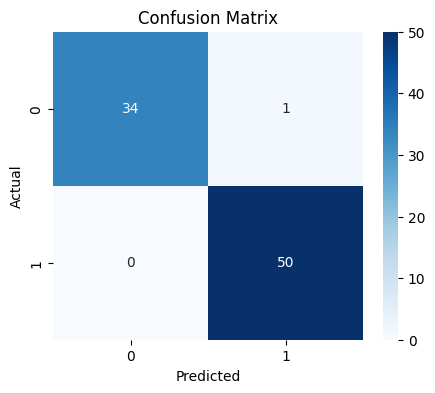

Positive - Approved, Negative - Counterfiet
True Negative: 34
False Positive: 1
False Negative: 0
True Positive: 50


In [9]:
def get_confusion_matrix_plot(actual_labels, predicted_labels):
    # Create the confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    tn, fp, fn, tp = confusion_matrix(actual_labels, predicted_labels, labels=[0, 1]).ravel()
    print("Positive - Approved, Negative - Counterfiet")
    print("True Negative:", tn)
    print("False Positive:", fp)
    print("False Negative:", fn)
    print("True Positive:", tp)
get_confusion_matrix_plot(actual_labels, predicted_labels)